<a href="https://colab.research.google.com/github/pratd/Facial-keypoints-detection/blob/master/Copy_of_Facial_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip to LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip


In [0]:
import zipfile
zip1 = zipfile.ZipFile('/content/LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip')
zip1.extractall()

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [4]:
### Useful routines for preparing data
import os
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
from glob import glob
import cv2
import csv
import pandas as pd
def load_imgs_and_keypoints(dirname='/content/facial-keypoints/data'):
    # Write your code for loading images and points here
    #imgs = []
    #for root, dirs, files in os.walk(dirname):  
    #    for filename in files:
    #        if filename.endswith('.png'):
    #            img = cv2.imread(os.path.join(root, filename), 0)
    #            img = resize(image, (100, 100))
    #            imgs.append(img)
    #for filename in glob('/home/pdatta/Downloads/LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints/facial-keypoints/data/images/*.jpg'): #assuming gif
    #    im=Image.open(filename)
    #   imgs.append(im)
    path = glob("/content/facial-keypoints/data/images/*.jpg")
    imgs = []
    h = []
    w = []
    name = []
    for root, dirs, dirfiles in os.walk(dirname):  
        for filename in dirfiles: 
            name.append(filename)
    
    for root, dirs, dirfiles in os.walk(dirname):  
        for filename in dirfiles:       
          if filename.endswith('.jpg'):
                img = imread(os.path.join(root, filename), 0)
                n = gray2rgb(img)
                h.append(n.shape[0])
                w.append(n.shape[1])
                img = resize(n, (100, 100))
                imgs.append(img)
    
    df = pd.read_csv("/content/facial-keypoints/data/gt.csv")
    df['order'] = df['filename'].apply(lambda v: name.index(v))
    df11 = df.sort_values(by=['order'])
    dff = df11.drop(columns=['order'])
    df2 = dff.filter(regex='y')
    df3 = dff.filter(regex='x')
    for i in range(df2.shape[1]):
      df2.iloc[:,i] = df2.iloc[:,i]/h 
      df3.iloc[:,i] = df3.iloc[:,i]/w
     
    df4 = pd.concat([df2, df3], axis=1)
    df4 = df4[[item for items in zip(df3.columns, df2.columns) for item in items]] 
    arr = df4.values -0.5
    points = arr
    return (imgs, points)

imgs, points = load_imgs_and_keypoints()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([-0.37671233, -0.06164384, -0.23972603, -0.17123288, -0.06164384,
       -0.26712329,  0.13013699, -0.37671233, -0.29452055, -0.02054795,
       -0.2260274 , -0.04794521, -0.17123288, -0.0890411 , -0.00684932,
       -0.21232877,  0.0890411 , -0.25342466,  0.14383562, -0.28082192,
       -0.04794521,  0.02054795, -0.00684932,  0.26712329,  0.07534247,
        0.18493151,  0.2260274 ,  0.11643836])

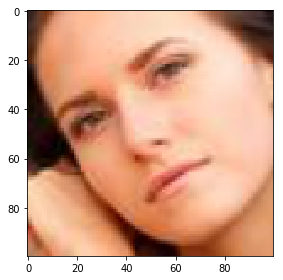

In [5]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

<Figure size 432x288 with 0 Axes>

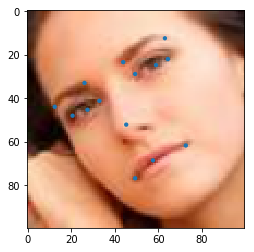

In [6]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    plt.clf()
    fig,ax = plt.subplots()
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(img)
    x = (points[0::2]+0.5)*100 #multiplied by 100 because of the new image size
    y = (points[1::2]+0.5)*100
    # Now, loop through coord arrays, and create a circle at each x,y pair
    for xx,yy in zip(x,y):
      circ = Circle((xx,yy),1)
      ax.add_patch(circ)
    
    plt.show() 
    
    
  
    
visualize_points(imgs[0], points[0])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [0]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

In [0]:
import numpy as np
def flip_img(img, points):
    # Write your code for flipping here
    f_img = zeros(img.shape)
    for j in range(img.shape[2]):
       f_img[:,:,j] = np.fliplr(img[:,:,j])
    
    x = points[0::2]
    y = points[1::2]
    x1= zeros(x.shape)
    y1= y
    for i in range(len(x)):
      x1[i] = (img.shape[1]-(x[i]+0.5)*img.shape[1] -1)/img.shape[1] -0.5
      #x1[i] = -x[]
    
    f_points1 = [ item for pair in zip(x1, y1) for item in pair]
    f_points = np.asarray(f_points1)
    
    return(f_img,f_points)
   

<Figure size 432x288 with 0 Axes>

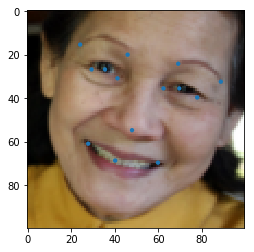

In [9]:
f_img,f_points = flip_img(imgs[501], points[501])
visualize_points(f_img, f_points)
#np.asarray(f_points)

In [10]:
f_points

array([ 0.3871872 , -0.17701261,  0.19126091, -0.25945684, -0.04152279,
       -0.30116392, -0.25975752, -0.34772066,  0.2785548 , -0.1042677 ,
        0.19611057, -0.14597478,  0.12336566, -0.14597478, -0.08807953,
       -0.19253152, -0.14530553, -0.23326867, -0.20738118, -0.23326867,
       -0.02115422,  0.04607177,  0.09814743,  0.19544132, -0.09874879,
        0.185742  , -0.2229001 ,  0.10814743])

In [11]:
points[501]

array([-0.3971872 , -0.17701261, -0.20126091, -0.25945684,  0.03152279,
       -0.30116392,  0.24975752, -0.34772066, -0.2885548 , -0.1042677 ,
       -0.20611057, -0.14597478, -0.13336566, -0.14597478,  0.07807953,
       -0.19253152,  0.13530553, -0.23326867,  0.19738118, -0.23326867,
        0.01115422,  0.04607177, -0.10814743,  0.19544132,  0.08874879,
        0.185742  ,  0.2129001 ,  0.10814743])

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
# Write your code here
import itertools
aug_imgs_train1 = []
aug_points_train1= []
for i in range(len(imgs_train)):
  f_image, f_point = flip_img(imgs_train[i],points_train[i])
  aug_imgs_train1.append(f_image)
  aug_points_train1.append(f_point)

In [0]:
aug_imgs_train = [ item for pair in zip(imgs_train, aug_imgs_train1) for item in pair]
aug_points_train = [ item for pair in zip(points_train, aug_points_train1) for item in pair]

In [14]:
#aug_imgs_train = np.append(imgs,aug_imgs_train1,axis=0)
#aug_points_train = np.append(points,aug_points_train1,axis=0)
len(aug_imgs_train)

10800

<Figure size 432x288 with 0 Axes>

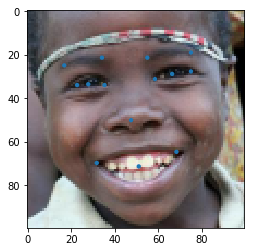

In [15]:
visualize_points(aug_imgs_train[303], aug_points_train[303])

<Figure size 432x288 with 0 Axes>

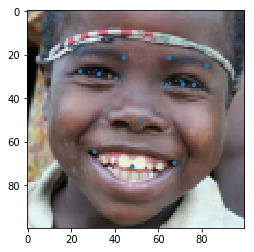

In [16]:
visualize_points(aug_imgs_train[302], aug_points_train[302])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [0]:
imgs_val = np.asarray(imgs_val)
points_val = np.asarray(points_val)
aug_imgs_train = np.asarray(aug_imgs_train)
aug_points_train = np.asarray(aug_points_train)

In [0]:
x_train = aug_imgs_train
x_val = imgs_val
y_val = points_val
y_train = aug_points_train
#from sklearn.utils import shuffle
#x_train,y_train= shuffle(aug_imgs_train,aug_points_train)
#x_val,y_val= shuffle(imgs_val,points_val)

<Figure size 432x288 with 0 Axes>

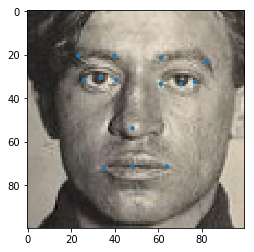

In [19]:
visualize_points(x_train[10],y_train[10])

In [29]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)

model = Sequential()
# Define here your model by adding layers
model.add(Conv2D(32, kernel_size=(3,3),strides=(1,1),padding='valid', activation='relu', input_shape=(100,100,3)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(rate = 0.2))


model.add(Conv2D(64,  kernel_size=(3,3),strides=(1,1),padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(rate = 0.2))



model.add(Conv2D(128,  kernel_size=(3,3),strides=(1,1),padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(rate = 0.2))


model.add(Conv2D(256,  kernel_size=(3,2), strides=(1,1),padding='valid', activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Dropout(rate = 0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(rate = 0.2))

model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(rate = 0.2))

#model.add(Dense(256, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(rate = 0.3))

model.add(Dense(28))



model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 9, 256)         196864    
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [30]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Nadam
batch_size = 128
epochs = 20
# Choose optimizer, compile model and run training
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.95, nesterov=True)

model.compile(loss = 'mse', optimizer = Adam(), metrics = ['mse'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, validation_data =(x_val, y_val) )
#score = model.evaluate(imgs_val, points_val, verbose=1)
#print('Test loss:', score[0])
#print('Test mse:', score[1])

Train on 10800 samples, validate on 600 samples
Epoch 1/20
10800/10800 [==============================] - 157s 14ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - val_loss: 0.0185 - val_mean_squared_error: 0.0185
Epoch 2/20
10800/10800 [==============================] - 155s 14ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 3/20
10800/10800 [==============================] - 156s 14ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 4/20
10800/10800 [==============================] - 158s 15ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 5/20
10800/10800 [==============================] - 155s 14ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 6/20
10800/10800 [==============================] - 155s 14ms/step - loss: 0.0163 - mean_squared_erro

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [0]:
# Example of output
points_predict = model.predict(imgs_val)

In [32]:
points_predict[1]

array([ 0.00909772, -0.33215654, -0.10144532, -0.27573293, -0.19719452,
       -0.18695104, -0.30234802, -0.11752543,  0.02650984, -0.25443047,
       -0.00420553, -0.23405203, -0.04383302, -0.19696942, -0.1494208 ,
       -0.11007909, -0.19090194, -0.09318251, -0.214655  , -0.0528288 ,
       -0.01876495,  0.0119444 ,  0.1634648 ,  0.09642181,  0.07943056,
        0.14457007,  0.02568228,  0.18942976], dtype=float32)

<Figure size 432x288 with 0 Axes>

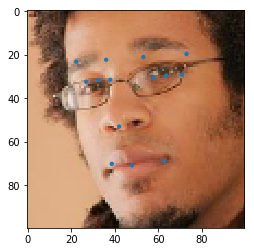

<Figure size 432x288 with 0 Axes>

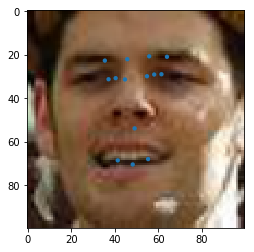

<Figure size 432x288 with 0 Axes>

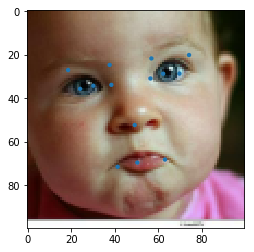

<Figure size 432x288 with 0 Axes>

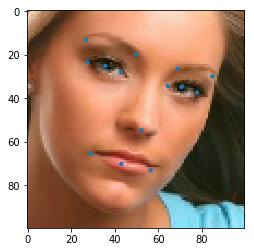

<Figure size 432x288 with 0 Axes>

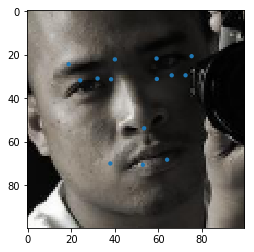

<Figure size 432x288 with 0 Axes>

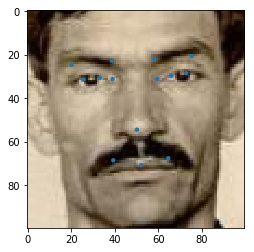

<Figure size 432x288 with 0 Axes>

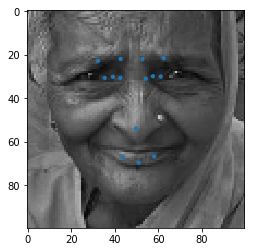

<Figure size 432x288 with 0 Axes>

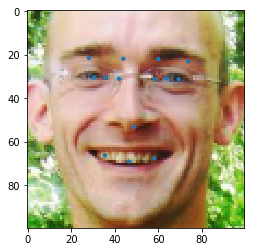

<Figure size 432x288 with 0 Axes>

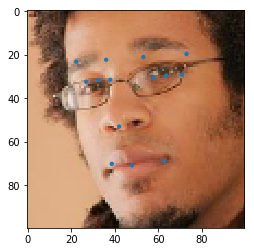

<Figure size 432x288 with 0 Axes>

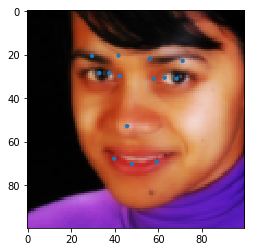

In [34]:
import random
for i in range(10):
  im = random.randint(1,600)
  visualize_points(imgs_val[im],points_predict[im])